In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

/Users/alexey/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#regexes for parsing the log files
def get_num_gpus(text):
    p = re.compile('\[batch = \d+ = \d+\*\d+\]')
    matches = p.findall(text)
    nums = re.findall(r'\d+',matches[0])
    return int(nums[-1])

def get_sync_percentages(text):
    p = re.compile('\[\d+.\d% calc., \d+.\d% synch.\]')
    matches = p.findall(text)[1:]
    nums = [float(re.findall(r'\d+.\d',match)[-1]) for match in matches]
    return np.mean(nums)/100
    
def get_loss(text):
    p = re.compile('loss: \d+\.\d+ ')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return nums[-1]

def get_losses(text):
    p = re.compile('loss: \d+\.\d+ ')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return np.array(nums)


#     return int(nums[-1])

def get_execution_time(text):
    p = re.compile('Epoch 2 finished in \d+.\d+ seconds')
    match = p.findall(text)[0]
    return float(re.findall(r'\d+\.\d',match)[-1])



def relative_array(arr):
    return arr/arr[0]

In [4]:
raw_path = './'
data_size = 'full' #full, large, medium
from os import listdir
from os.path import isfile, join
files = [join(raw_path,f) for f in listdir(raw_path) if (isfile(join(raw_path, f)) and data_size in f)]

In [6]:
import re
node_counts = [get_num_gpus(open(f).read()) for f in files]
files = list(zip(*sorted(zip(node_counts,files)))[1])
files
node_counts = np.array([get_num_gpus(open(f).read()) for f in files])
sync_percentages =np.array([get_sync_percentages(open(f).read()) for f in files] )
execution_times =np.array([get_execution_time(open(f).read()) for f in files])
losses = np.array([get_loss(open(f).read()) for f in files])
loss_arrays = [get_losses(open(f).read()) for f in files]

In [7]:
communication_work = sync_percentages/(1-sync_percentages)
scaled_execution_times = execution_times*node_counts
fictitious_node_counts = np.logspace(np.log10(4),np.log10(10000),100)
communication_work_extended = communication_work[-1]/np.log(node_counts[-1])*np.log(fictitious_node_counts)
modeled_execution_times = execution_times[0]*node_counts[0]/fictitious_node_counts*(1 + communication_work_extended)
scaled_modeled_execution_times = fictitious_node_counts*modeled_execution_times


In [8]:
loss_arrays[-1]

array([  1.17042000e+00,   7.59810000e-01,   5.18710000e-01,
         3.91260000e-01,   3.16090000e-01,   2.66340000e-01,
         2.31080000e-01,   2.05950000e-01,   1.85320000e-01,
         1.85260000e-01,   1.71010000e-01,   1.61710000e-01,
         1.56590000e-01,   1.53810000e-01,   1.50900000e-01,
         1.46120000e-01,   1.41200000e-01,   1.35560000e-01,
         1.29820000e-01,   1.24180000e-01,   1.19010000e-01,
         1.14300000e-01,   1.03000000e-03,   5.20000000e-04,
         5.30000000e-04,   6.50000000e-04,   1.01000000e-03,
         1.39000000e-03,   1.82000000e-03,   2.60000000e-03,
         3.48000000e-03,   4.32000000e-03,   5.29000000e-03,
         6.53000000e-03,   7.91000000e-03,   9.45000000e-03,
         1.09100000e-02,   1.17100000e-02,   1.24200000e-02,
         1.30600000e-02,   1.33300000e-02,   1.33400000e-02,
         1.33400000e-02,   1.32800000e-02])

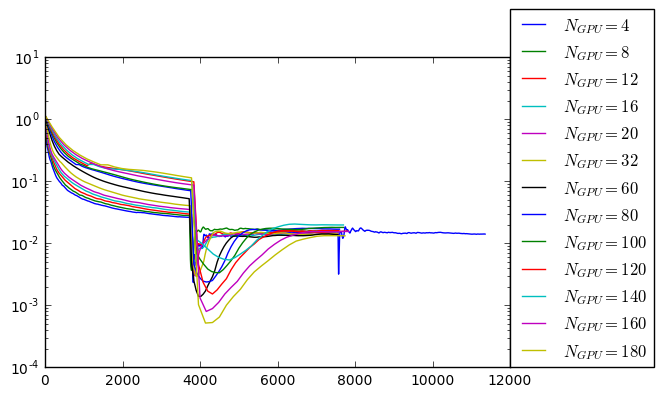

In [9]:
for (i,loss_arr) in enumerate(loss_arrays):
    plt.semilogy(np.array(range(len(loss_arr)))*node_counts[i],loss_arr,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.legend(loc=(1,0))

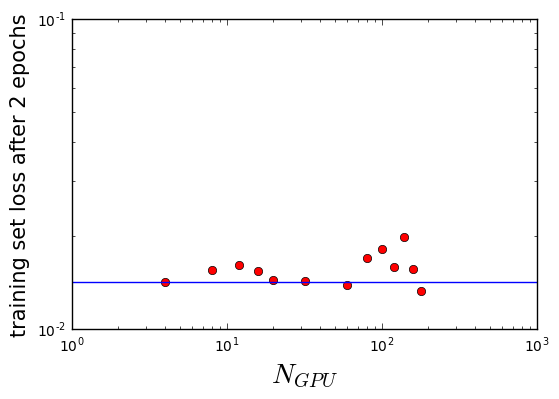

In [10]:
for (i,loss_arr) in enumerate(loss_arrays):
    plt.loglog(node_counts[i],loss_arr[-1],"or")#,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.axhline(loss_arrays[0][-1])
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"training set loss after 2 epochs",size=15)
# plt.legend(loc=(1,0))

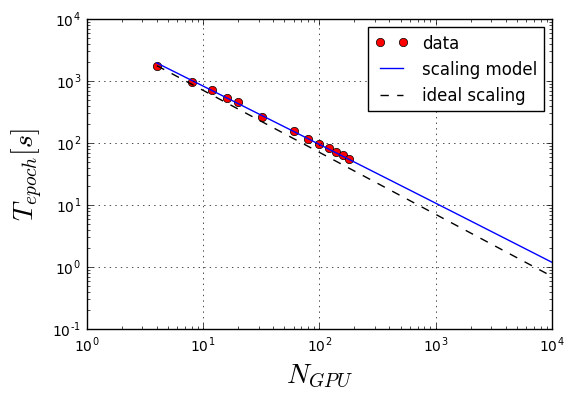

In [11]:
plt.loglog(node_counts,execution_times,'or',label="data")
plt.loglog(fictitious_node_counts,modeled_execution_times,label="scaling model")
plt.loglog(fictitious_node_counts,execution_times[0]*node_counts[0]/fictitious_node_counts,'--k',label="ideal scaling")
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{epoch} [s]$",size=20)
plt.grid()
plt.legend(loc="best")

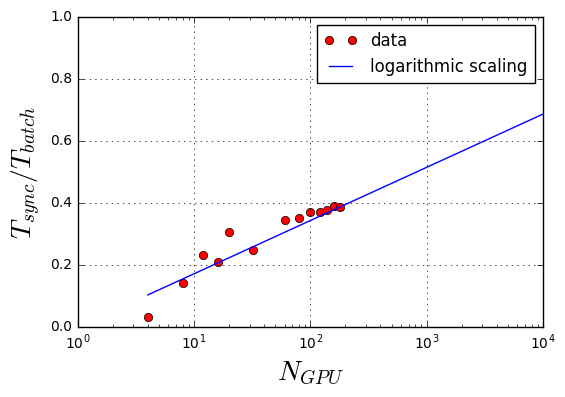

In [12]:
#logarithmic scaling of communication work!
# plt.semilogx(node_counts,communication_work/relative_array(np.log(node_counts)),'ro')
# plt.semilogx(fictitious_node_counts,communication_work_extended/relative_array(np.log(fictitious_node_counts)),'-')
plt.semilogx(node_counts,communication_work,'ro',label='data')
plt.semilogx(fictitious_node_counts,communication_work_extended,'-',label="logarithmic scaling")
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{sync}/T_{batch}$",size=20)
plt.ylim([0,1])
plt.legend(loc="best")

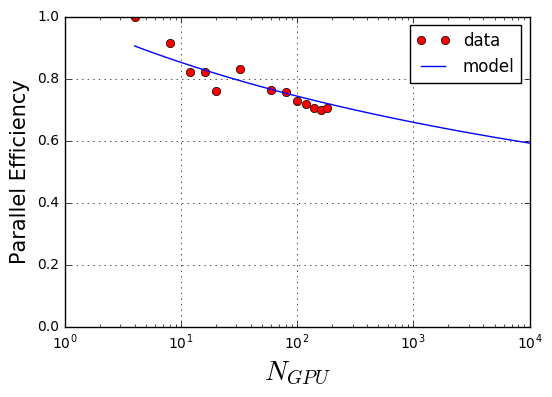

In [13]:
plt.semilogx(node_counts,scaled_execution_times[0]/scaled_execution_times,'ro',label="data")
plt.semilogx(fictitious_node_counts,scaled_execution_times[0]/scaled_modeled_execution_times,'-',label="model")
plt.ylim([0,1])
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"Parallel Efficiency",size=15)
plt.legend(loc="best")

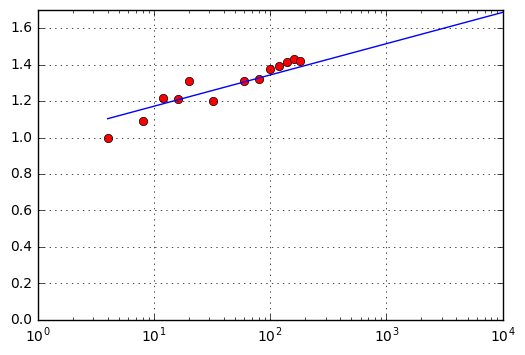

In [14]:
plt.semilogx(node_counts,scaled_execution_times/scaled_execution_times[0],'ro')
plt.semilogx(fictitious_node_counts,scaled_modeled_execution_times/scaled_execution_times[0],'-')
plt.ylim(0)
plt.grid()

In [62]:
#Full dataset
node_cnts = [1,2,3,4,5,8,15,20,25,30,35,40]
gpu_cnts = map(lambda x: 4*x,node_cnts)
times = [1761.87,961.37,715.14,534.72,462.46,264.68,153.94,116.33,96.91,81.71,71.32,62.97]
relative_times = map(lambda x: x/times[0], times)
scaled_times = list()
for n,t in zip(node_cnts,times):
    scaled_times.append(100.0*times[0]/(n*t))
ave_losses = [0.01581,0.01544,0.01607,0.01539,0.01435,0.01425,0.01386,0.01699,0.01812,0.01580,0.01986,0.01561]

#data_full_lists = list()
#for n,t,a in zip(node_cnts,times,ave_losses):
#    data_full = {"node_cnt":0,"time":0.0,"ave_loss":0.0}
#    data_full['node_cnt'] = n
#    data_full['time'] = t
#    data_full['ave_loss'] = a
#    data_full_lists.append(data_full)

In [63]:
#import pandas as pd
#data_full_pd = pd.DataFrame(data_full_lists) 

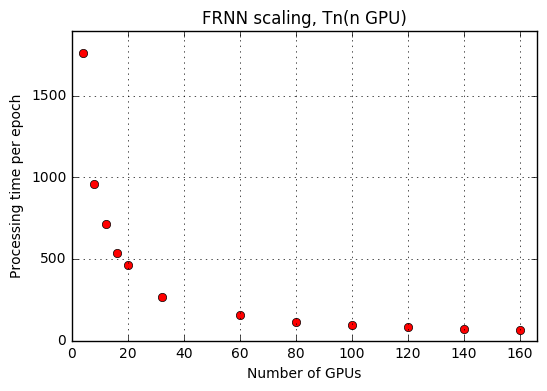

In [64]:
plt.title('FRNN scaling, Tn(n GPU)')
plt.plot(gpu_cnts,times, 'ro')
plt.axis([0, 166, 0, 1900])
plt.xlabel('Number of GPUs')
plt.ylabel('Processing time per epoch')
plt.grid(True)
plt.show()

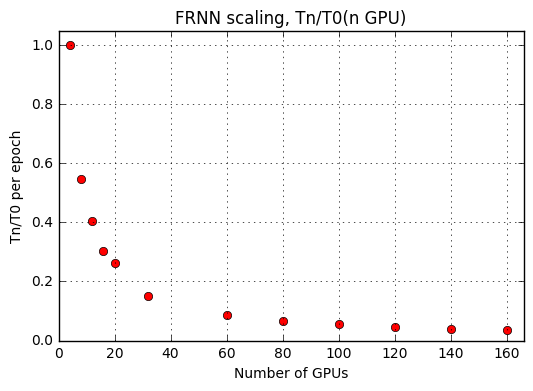

In [65]:
plt.title('FRNN scaling, Tn/T0(n GPU)')
plt.plot(gpu_cnts,relative_times, 'ro')
plt.axis([0, 166, 0, 1.05])
plt.xlabel('Number of GPUs')
plt.ylabel('Tn/T0 per epoch')
plt.grid(True)
plt.show()

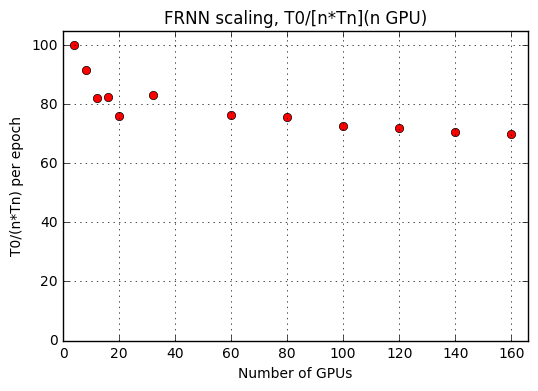

In [66]:
plt.title('FRNN scaling, T0/[n*Tn](n GPU)')
plt.plot(gpu_cnts,scaled_times, 'ro')
plt.axis([0, 166, 0, 105])
plt.xlabel('Number of GPUs')
plt.ylabel('T0/(n*Tn) per epoch')
plt.grid(True)
plt.show()

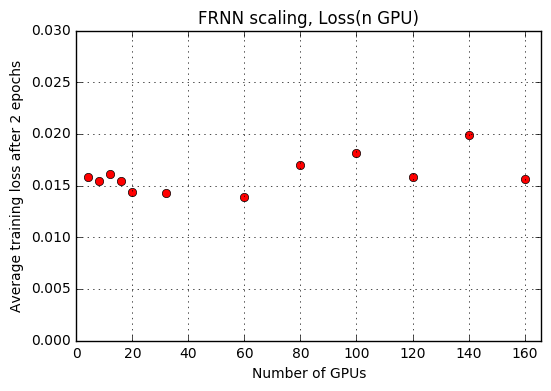

In [67]:
plt.title('FRNN scaling, Loss(n GPU)')
plt.plot(gpu_cnts,ave_losses, 'ro')
plt.axis([0, 166, 0.00, 0.03])
plt.xlabel('Number of GPUs')
plt.ylabel('Average training loss after 2 epochs')
plt.grid(True)
plt.show()

# Speedup vs dataset size

In [68]:
#Full dataset
node_cnts = [1,2,3,4,5,8]
gpu_cnts = map(lambda x: 4*x,node_cnts)
full_times = [1761.87,961.37,715.14,534.72,462.46,264.68]
large_times = [45.69,26.77,20.33,15.80,14.80,9.42]
medium_times = [26.14,16.93,13.83,11.45,9.87,7.30]
small_times = [9.64,6.78,7.16,5.04,5.30,5.19]

from math import log
def speedup(Nrows,Ngpu):
    return Nrows/((Nrows/Ngpu) + 2*log(Ngpu))

full_scaled_times = list()
for n,t in zip(node_cnts,full_times):
    full_scaled_times.append(100.0*full_times[0]/(n*t))

large_scaled_times = list()
for n,t in zip(node_cnts,large_times):
    large_scaled_times.append(100.0*large_times[0]/(n*t))
    
medium_scaled_times = list()
for n,t in zip(node_cnts,medium_times):
    medium_scaled_times.append(100.0*medium_times[0]/(n*t))
    
small_scaled_times = list()
for n,t in zip(node_cnts,small_times):
    small_scaled_times.append(100.0*small_times[0]/(n*t))    

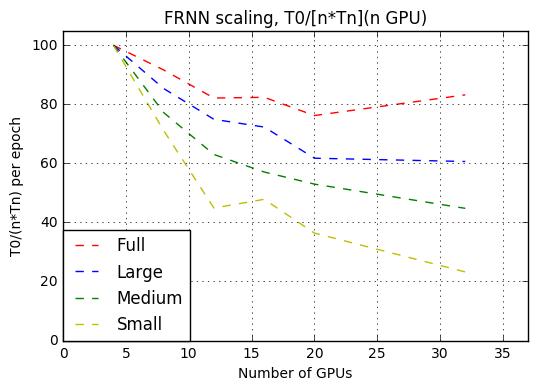

In [69]:
plt.title('FRNN scaling, T0/[n*Tn](n GPU)')
plt.plot(gpu_cnts,full_scaled_times, 'r--',label="Full")
plt.plot(gpu_cnts,large_scaled_times, 'b--',label="Large")
plt.plot(gpu_cnts,medium_scaled_times, 'g--',label="Medium")
plt.plot(gpu_cnts,small_scaled_times, 'y--',label="Small")

plt.axis([0, 37, 0, 105])
plt.xlabel('Number of GPUs')
plt.ylabel('T0/(n*Tn) per epoch')
plt.grid(True)
plt.legend(loc=3,borderaxespad=0.)
plt.show()
